In [1]:
import pandas as pd
from tensorflow import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from keras.callbacks import EarlyStopping

#### Functions

In [2]:
df = pd.read_csv('Volve production data.csv', sep =';', decimal = ',' )
columns_df = list(df)
display(columns_df)

filtro = df.WELL_BORE_CODE == 'NO 15/9-F-1 C'
df2 = df.loc[filtro]

data = pd.DataFrame()
columns = ['AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

for element in columns:
    data[element] = df2[element].astype(float)
    
data.dropna(inplace = True)
data = data.reindex(columns = ['BORE_OIL_VOL','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS','BORE_GAS_VOL', 'BORE_WAT_VOL'])
print(type(data))

data

['DATEPRD',
 'WELL_BORE_CODE',
 'NPD_WELL_BORE_CODE',
 'NPD_WELL_BORE_NAME',
 'NPD_FIELD_CODE',
 'NPD_FIELD_NAME',
 'NPD_FACILITY_CODE',
 'NPD_FACILITY_NAME',
 'ON_STREAM_HRS',
 'AVG_DOWNHOLE_PRESSURE',
 'AVG_DOWNHOLE_TEMPERATURE',
 'AVG_DP_TUBING',
 'AVG_ANNULUS_PRESS',
 'AVG_CHOKE_SIZE_P',
 'AVG_CHOKE_UOM',
 'AVG_WHP_P',
 'AVG_WHT_P',
 'DP_CHOKE_SIZE',
 'BORE_OIL_VOL',
 'BORE_GAS_VOL',
 'BORE_WAT_VOL',
 'BORE_WI_VOL',
 'FLOW_KIND',
 'WELL_TYPE']

<class 'pandas.core.frame.DataFrame'>


,BORE_OIL_VOL,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,ON_STREAM_HRS,BORE_GAS_VOL,BORE_WAT_VOL
0,0.0,0.000,0.000,0.00000,0.0,0.0,0.0
4,0.0,310.376,96.876,1.21599,0.0,0.0,0.0
5,0.0,303.501,96.923,3.08702,0.0,0.0,0.0
6,0.0,303.535,96.959,1.96237,0.0,0.0,0.0
7,0.0,303.782,96.969,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
741,0.0,270.268,101.198,0.00000,0.0,0.0,0.0
742,0.0,276.869,101.231,0.00000,0.0,0.0,0.0
743,0.0,282.105,101.178,0.26519,0.0,0.0,0.0
744,0.0,285.096,101.131,0.00000,0.0,0.0,0.0


In [3]:
def create_dataset(timestamp, data):
    X = []
    y = []
    for i in range(timestamp,len(data)):
        
        data_X = data.iloc[:,1:-1]       
        X.append(data[i-timestamp:i,:])
        y.append(data.iloc[i,0])
        
        if i <= timestamp:
            print(len(X))
            print(X)
            print(y)
        
    return np.array(X), np.array(y)

In [4]:
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target = scaler_target.fit(data['BORE_OIL_VOL'].values.reshape(-1,1))

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(np.array(data))

df_normalized = pd.DataFrame(scaler.fit_transform(np.array(data)), columns = columns)
df_normalized = df_normalized.reindex(columns = ['BORE_OIL_VOL','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS','BORE_GAS_VOL', 'BORE_WAT_VOL'])

display(df_normalized)

,BORE_OIL_VOL,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,ON_STREAM_HRS,BORE_GAS_VOL,BORE_WAT_VOL
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.892850,0.0,0.988865,0.0,0.0,0.012986,0.0
2,0.893283,0.0,0.966961,0.0,0.0,0.032969,0.0
3,0.893615,0.0,0.967069,0.0,0.0,0.020958,0.0
4,0.893707,0.0,0.967856,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
738,0.932683,0.0,0.861080,0.0,0.0,0.000000,0.0
739,0.932987,0.0,0.882111,0.0,0.0,0.000000,0.0
740,0.932499,0.0,0.898793,0.0,0.0,0.002832,0.0
741,0.932066,0.0,0.908322,0.0,0.0,0.000000,0.0


In [6]:
look_back = 1
test_size = 0.2

train_index = int(data.shape[0]*(1-test_size))

train_data = df_normalized.iloc[:train_index,:].values
test_data = df_normalized.iloc[train_index:,:].values

# split into input and outputs
train_X, train_y = train_data[:, 1:], train_data[:, 0]
test_X, test_y = test_data[:, 1:], test_data[:, 0]

train_X = train_X.reshape((train_X.shape[0], look_back, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], look_back, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#_, y_expected = create_dataset(look_back, data.iloc[train_index:-1:0].values)

#print(y_expected.shape)

(594, 1, 6) (594,) (149, 1, 6) (149,)


In [7]:
train_X

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.        , 0.98886485, 0.        , 0.        , 0.01298643,
         0.        ]],

       [[0.        , 0.96696095, 0.        , 0.        , 0.0329685 ,
         0.        ]],

       ...,

       [[0.31237113, 0.77855234, 0.0891286 , 0.00104137, 0.64788628,
         0.96      ]],

       [[0.31340206, 0.76411647, 0.08870633, 0.0010444 , 0.64740259,
         0.96      ]],

       [[0.31030928, 0.75219756, 0.08754319, 0.91826438, 0.64733371,
         0.96      ]]])

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target = scaler_target.fit(np.array(data[:,0]))

# transform train
train_data_y = np.array(train_data)
test_data_y = data.iloc[train_index:-1,:].values

train_data_y = train_data_y.reshape(-1, 1)
train_scaled = scaler_target.transform(train_data_y)

# transform test
test_data_y = test_data_y.reshape(-1, 1)
test_scaled = scaler_target.transform(test_data_y)

trainX, trainy = create_dataset(look_back, train_data)
testX, testy = create_dataset(look_back, test_data)

print(trainX.shape)

train_data = np.reshape(trainX, (trainX.shape[0], look_back, 1))

test_data = np.reshape(testX, (testX.shape[0], look_back, 1))
print(train_data.shape)
print(test_data.shape)

In [8]:
model = Sequential()
model.add(LSTM(40, return_sequences = True, input_shape = (train_X.shape[1],train_X.shape[2])))
model.add(LSTM(40, return_sequences = False))
model.add(Dense(20, activation = 'tanh'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 40)             7520      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21,321
Trainable params: 21,321
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
534/534 - 6s - loss: 0.0137 - val_loss: 0.0010 - 6s/epoch - 11ms/step
Epoch 2/10
534/534 - 1s - loss: 0.0024 - val_loss: 9.2604e-04 - 1s/epoch - 2ms/step
Epoch 3/10
534/534 - 1s - loss: 0.0023 - val_loss: 8.5717e-04 - 1s/epoch - 2ms/step
Epoch 4/10
534/534 - 1s - loss: 0.0023 - val_loss: 7.9354e-04 - 1s/epoch - 2ms/step
Epoch 5/10
534/534 - 1s - loss: 0.0022 - val_loss: 7.3472e-04 - 1s/epoch - 2ms/step
Epoch 6/10
534/534 - 1s - loss: 0.0022 - val_loss: 6.8032e-04 - 1s/epoch - 2ms/step
Epoch 7/10
534/534 - 1s - loss: 0.0022 - val_loss: 6.3001e-04 - 1s/epoch - 2ms/step
Epoch 8/10
534/534 - 1s - loss: 0.0021 - val_loss: 5.8352e-04 - 1s/epoch - 2ms/step
Epoch 9/10
534/534 - 1s - loss: 0.0021 - val_loss: 5.4059e-04 - 1s/epoch - 2ms/step
Epoch 10/10
534/534 - 1s - loss: 0.0021 - val_loss: 5.0098e-04 - 1s/epoch - 2ms/step


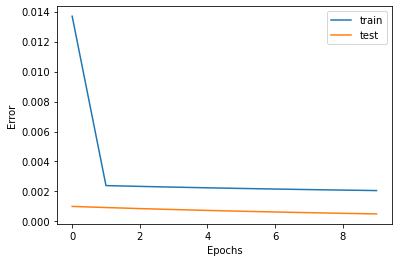

In [9]:
model.compile(optimizer = 'sgd', loss = 'mean_squared_error')

history  = model.fit(train_X,train_y, batch_size = 1, epochs = 10,  validation_split = 0.1, verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

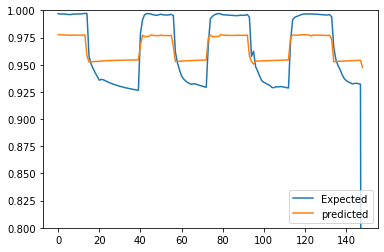

0.08007630679388304


In [11]:
y_pred = model.predict(test_X)

#y_pred = scaler_target.inverse_transform(y_pred)

RMSE = MSE(test_y,y_pred)**0.5

plt.plot(test_y, label='Expected')
plt.plot(y_pred, label='predicted')
plt.ylim(0.8,1)
plt.legend(loc ='lower right')

plt.show()


print(RMSE)

In [22]:
model2 = Sequential()

#ENCODER
model2.add(Dense(16, input_shape = (train_X.shape[1],train_X.shape[2])))
model2.add(Dense(8, activation = 'tanh'))
model2.add(Dense(2, activation = 'relu'))

#DECODER
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(16, activation = 'tanh'))

#LSTM
model2.add(LSTM(40, return_sequences = True))
model2.add(LSTM(40, return_sequences = False))

#OUTPUT
model2.add(Dense(20, activation = 'tanh'))
model2.add(Dense(1))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 16)             112       
                                                                 
 dense_10 (Dense)            (None, 1, 8)              136       
                                                                 
 dense_11 (Dense)            (None, 1, 2)              18        
                                                                 
 dense_12 (Dense)            (None, 1, 8)              24        
                                                                 
 dense_13 (Dense)            (None, 1, 16)             144       
                                                                 
 lstm_4 (LSTM)               (None, 1, 40)             9120      
                                                                 
 lstm_5 (LSTM)               (None, 40)               

Epoch 1/50
534/534 - 6s - loss: 0.0021 - val_loss: 4.5365e-04 - 6s/epoch - 12ms/step
Epoch 2/50
534/534 - 1s - loss: 0.0021 - val_loss: 4.3483e-04 - 1s/epoch - 3ms/step
Epoch 3/50
534/534 - 1s - loss: 0.0021 - val_loss: 4.1678e-04 - 1s/epoch - 3ms/step
Epoch 4/50
534/534 - 1s - loss: 0.0021 - val_loss: 3.9834e-04 - 1s/epoch - 2ms/step
Epoch 5/50
534/534 - 1s - loss: 0.0020 - val_loss: 3.8089e-04 - 1s/epoch - 3ms/step
Epoch 6/50
534/534 - 1s - loss: 0.0020 - val_loss: 3.6312e-04 - 1s/epoch - 3ms/step
Epoch 7/50
534/534 - 1s - loss: 0.0020 - val_loss: 3.4657e-04 - 1s/epoch - 2ms/step
Epoch 8/50
534/534 - 1s - loss: 0.0020 - val_loss: 3.3003e-04 - 1s/epoch - 3ms/step
Epoch 9/50
534/534 - 1s - loss: 0.0020 - val_loss: 3.1475e-04 - 1s/epoch - 3ms/step
Epoch 10/50
534/534 - 1s - loss: 0.0020 - val_loss: 2.9975e-04 - 1s/epoch - 2ms/step
Epoch 11/50
534/534 - 1s - loss: 0.0020 - val_loss: 2.8621e-04 - 1s/epoch - 2ms/step
Epoch 12/50
534/534 - 1s - loss: 0.0020 - val_loss: 2.7313e-04 - 1s/epoch

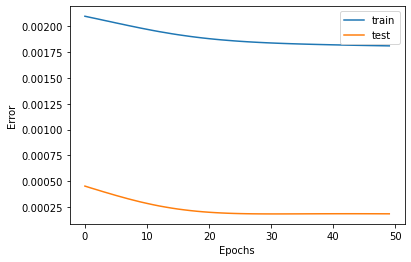

In [27]:
model2.compile(optimizer = 'sgd', loss = 'mean_squared_error')

early_stopping_monitor = EarlyStopping(patience = 15)

history  = model2.fit(train_X,train_y, batch_size = 1, epochs = 50,
                      validation_split = 0.1, verbose=2, shuffle=False
                     #,callbacks = [early_stopping_monitor]
                     )

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

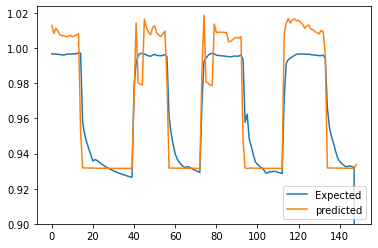

0.07775531823459006


In [29]:
y_pred_test = model2.predict(test_X)
y_pred_train = model2.predict(train_X)

#y_pred = scaler_target.inverse_transform(y_pred)

RMSE = MSE(test_y,y_pred_test)**0.5

plt.plot(test_y, label='Expected')
plt.plot(y_pred_test, label='predicted')
plt.ylim(0.9,y_pred_test.max()*1.005)
plt.legend(loc ='lower right')

plt.show()


print(RMSE)

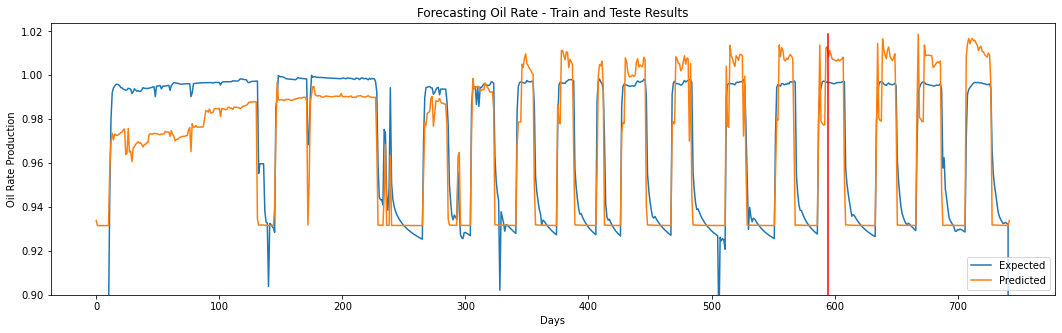

In [30]:
x_axis = np.arange(0, data.shape[0])
y_plot = np.linspace(0,y_pred_test.max(), num = data.shape[0])
x_plot = list(map(lambda x: train_index+1, x_axis))

y_pred_train = model2.predict(train_X)

predictions = np.concatenate((y_pred_train, y_pred_test), axis=0)

fig = plt.figure(figsize=(18, 5))
plt.plot(x_axis, df_normalized.iloc[:,0], label='Expected')
plt.plot(x_axis, predictions, label='Predicted')
plt.title('Forecasting Oil Rate - Train and Teste Results')
plt.ylabel('Oil Rate Production')
plt.xlabel('Days')

plt.ylim(0.9,y_pred_test.max()*1.005)

plt.plot(x_plot, y_plot, 'r', linestyle='-')
plt.legend(loc ='lower right')

In [ ]:
predictions.shape

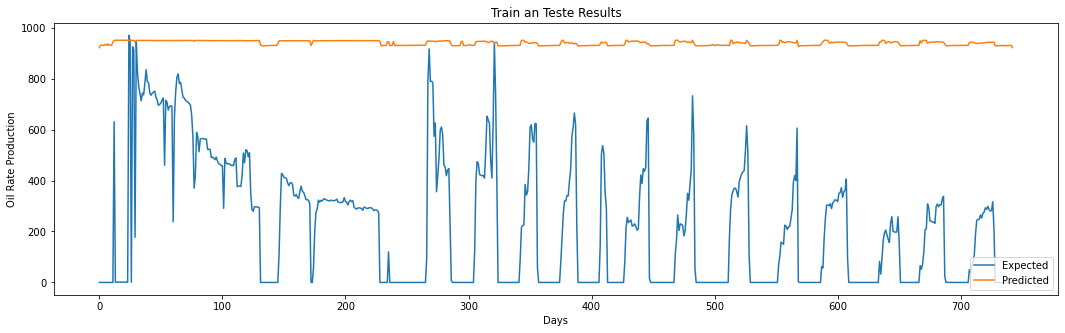

In [21]:
predictions_ = df_normalized.copy()

predictions_['BORE_OIL_VOL'] = predictions
predictions_ = scaler.inverse_transform(predictions_)

fig = plt.figure(figsize=(18, 5))
plt.plot(x_axis, data.iloc[:,0], label='Expected')
plt.plot(x_axis, predictions_[:,0], label='Predicted')
plt.title('Train an Teste Results')
plt.ylabel('Oil Rate Production')
plt.xlabel('Days')
#plt.annotate(f'r-squared = {R2_treinamento1}', (0,0.9))
#plt.ylim(0,y_pred.max()*1.005)
#fig.add_artist(lines.Line2D([524, 200], [524, 320]))
plt.plot(x_plot, y_plot, 'r', linestyle='-')
plt.legend(loc ='lower right')